In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize
#from numpy import zeros
#from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, clean_strings, get_redundaunt_info, is_in_words
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger

In [3]:
DetectorFactory.seed = 0

in_file = open("in_file.cfg").read()
in_file = in_file.split("\n")
patterns_file = in_file[5]
file_folder = in_file[4]
label = in_file[3]
col = in_file[2]
in_type = in_file[1]
in_file = in_file[0]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

In [4]:
strings.head()

0    nan nan Rentier person of private means\nThe B...
1    nan nan nan Buona parte del patrimonio è inves...
2    nan nan fattuarato 2010 27 mio EUR.  software ...
3    nan nan A is part of the Washington Marine Gro...
4    nan nan The company B Russia produces solar ba...
Name: text, dtype: object

In [5]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    from re import findall
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings.head()
    strings = filter_recipients(strings)
    strings.head()
    strings = filter_data(strings)
    strings.head()
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))


In [6]:
strings = strings.apply(clean_strings)

In [7]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]
# hit_strings = strings[hits]

In [8]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

In [9]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len).tolist()
# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

In [10]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: " ".join(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [11]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [12]:
sentences1

0    rentier person of private means the bo is the ...
3    a is part of the washington marine group which...
4    the company b russia produces solar batteries ...
5    b is one of the largest law firms specializing...
6    s is part of the which is owned by the busines...
Name: text, dtype: object

In [13]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [14]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

In [15]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")

out_file.close()

In [16]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

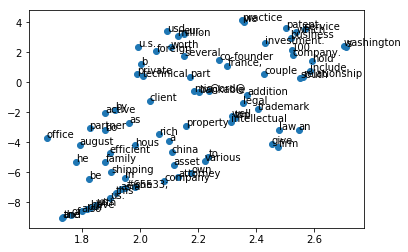

In [17]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [18]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

In [19]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

In [20]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [21]:
sim1 = get_semantic_similarity(model)

In [22]:
vocab = list(model.wv.vocab)

In [23]:
ratio = get_character_similarity(vocab, 'ratio')

In [24]:
partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [25]:
token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [26]:
token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [27]:
sim1 = sim1[ratio.columns]
sim1 = sim1.loc[ratio.columns]

In [28]:
semantic_weight = 0.5
ratio_weight = 0.4
partial_ratio_weight = 0.4
token_sort_ratio_weight = 0.1
sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
dist = 1 - sim

In [29]:
aff = run_aff_prop_with_distances(dist)

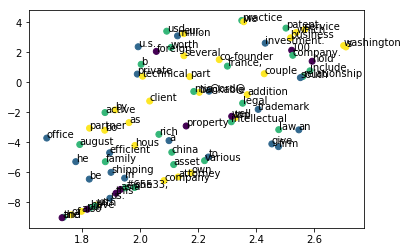

In [30]:
visualize_word2vec_model(model, aff.labels_)

In [31]:
columns = sim.columns
condition = Series(sim.columns).apply(is_in_words)
sim = sim.loc[columns[~condition]]
sim = sim[columns[condition]]

In [32]:
sim.apply(lambda x: x.sort_values().index[0], axis = 1)

#65533;        practice
100            practice
@ord@                we
bankable          which
bo             practice
co-founder     practice
company.             we
eur.           practice
france,               s
hous           practice
investment.           b
mio.                 we
u.s.           practice
us.            practice
usd            practice
dtype: object

In [33]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

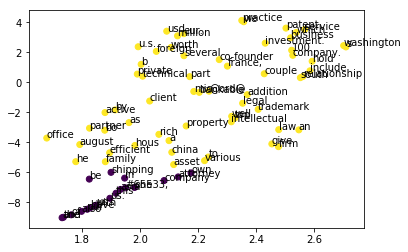

In [34]:
visualize_word2vec_model(model, km.cluster)

In [35]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

In [36]:
lda_model.print_topics(-1)

[(0,
  '0.006*"scientific" + 0.006*"enable" + 0.006*"abroad" + 0.006*"guide" + 0.006*"principle" + 0.006*"teamwork" + 0.006*"respect" + 0.006*"quality" + 0.006*"emphasis" + 0.006*"international"'),
 (1,
  '0.006*"scientific" + 0.006*"enable" + 0.006*"abroad" + 0.006*"guide" + 0.006*"principle" + 0.006*"teamwork" + 0.006*"respect" + 0.006*"quality" + 0.006*"emphasis" + 0.006*"international"'),
 (2,
  '0.006*"scientific" + 0.006*"enable" + 0.006*"abroad" + 0.006*"guide" + 0.006*"principle" + 0.006*"teamwork" + 0.006*"respect" + 0.006*"quality" + 0.006*"emphasis" + 0.006*"international"'),
 (3,
  '0.006*"scientific" + 0.006*"enable" + 0.006*"abroad" + 0.006*"guide" + 0.006*"principle" + 0.006*"teamwork" + 0.006*"respect" + 0.006*"quality" + 0.006*"emphasis" + 0.006*"international"'),
 (4,
  '0.068*"company" + 0.050*"us" + 0.047*"one" + 0.047*"also" + 0.027*"business" + 0.026*"co-founder" + 0.026*"worth" + 0.026*"south" + 0.026*"active" + 0.026*"give"'),
 (5,
  '0.006*"scientific" + 0.006*

In [37]:
from util import get_word_lda_topics
Series(list(model.wv.vocab.keys())).apply(lambda x: get_word_lda_topics(x))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
      ... 
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
59    None
60    None
61    None
62    None
63    None
64    None
65    None
66    None
67    None
68    None
69    None
70    None
71    None
72    None
73    None
74    None
75    None
76    None
77    None
78    None
79    None
Length: 80, dtype: object

In [40]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)


PreparedData(topic_coordinates=            Freq  cluster  topics                      x  \
topic                                                      
85     67.638406        1       1    (0.165851241758+0j)   
32     31.321483        1       2   (-0.359317192836+0j)   
4       0.010613        1       3   (-0.339421438467+0j)   
99      0.010613        1       4  (0.00318004012639+0j)   
26      0.010613        1       5  (0.00318004012639+0j)   
27      0.010613        1       6  (0.00318004012639+0j)   
28      0.010613        1       7  (0.00318004012639+0j)   
29      0.010613        1       8  (0.00318004012639+0j)   
30      0.010613        1       9  (0.00318004012639+0j)   
31      0.010613        1      10  (0.00318004012639+0j)   
33      0.010613        1      11  (0.00318004012639+0j)   
34      0.010613        1      12  (0.00318004012639+0j)   
35      0.010613        1      13  (0.00318004012639+0j)   
36      0.010613        1      14  (0.00318004012639+0j)   
24      0.010613        1      15  (0.00318004012639+0j)   
37      0.010613        1      16  (0.00318004012639+0j)   
38      0.010613        1      17   (0.0853480888554+0j)   
39      0.010613        1      18  (0.00318004012639+0j)   
40      0.010613        1      19  (0.00318004012639+0j)   
41      0.010613        1      20  (0.00318004012639+0j)   
42      0.010613        1      21    (0.151989372612+0j)   
43      0.010613        1      22  (0.00318004012639+0j)   
44      0.010613        1      23  (0.00318004012639+0j)   
45      0.010613        1      24  (0.00318004012639+0j)   
46      0.010613        1      25  (0.00318004012639+0j)   
25      0.010613        1      26  (0.00318004012639+0j)   
23      0.010613        1      27  (0.00318004012639+0j)   
48      0.010613        1      28  (0.00318004012639+0j)   
11      0.010613        1      29  (0.00318004012639+0j)   
1       0.010613        1      30  (0.00318004012639+0j)   
...          ...      ...     ...                    ...   
94      0.010613        1      71  (0.00318004012639+0j)   
95      0.010613        1      72  (0.00318004012639+0j)   
96      0.010613        1      73  (0.00318004012639+0j)   
97      0.010613        1      74  (0.00318004012639+0j)   
75      0.010613        1      75  (0.00318004012639+0j)   
73      0.010613        1      76  (0.00318004012639+0j)   
50      0.010613        1      77  (0.00318004012639+0j)   
72      0.010613        1      78  (0.00318004012639+0j)   
51      0.010613        1      79  (0.00318004012639+0j)   
52      0.010613        1      80  (0.00318004012639+0j)   
53      0.010613        1      81  (0.00318004012639+0j)   
54      0.010613        1      82  (0.00318004012639+0j)   
55      0.010613        1      83  (0.00318004012639+0j)   
56      0.010613        1      84  (0.00318004012639+0j)   
57      0.010613        1      85  (0.00318004012639+0j)   
58      0.010613        1      86    (0.136256865299+0j)   
59      0.010613        1      87  (0.00318004012639+0j)   
60      0.010613        1      88  (0.00318004012639+0j)   
61      0.010613        1      89  (0.00318004012639+0j)   
62      0.010613        1      90  (0.00318004012639+0j)   
63      0.010613        1      91  (0.00318004012639+0j)   
64      0.010613        1      92  (0.00318004012639+0j)   
65      0.010613        1      93  (0.00318004012639+0j)   
66      0.010613        1      94  (0.00318004012639+0j)   
67      0.010613        1      95  (0.00318004012639+0j)   
68      0.010613        1      96  (0.00318004012639+0j)   
69      0.010613        1      97  (0.00318004012639+0j)   
70      0.010613        1      98  (0.00318004012639+0j)   
71      0.010613        1      99  (0.00318004012639+0j)   
0       0.010613        1     100  (0.00318004012639+0j)   

                             y  
topic                           
85       (0.00775628640408+0j)  
32       (-0.0280871411637+0j)  
4         (0.0226766247903+0j)  
99     (-4.88029610312e